Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.3.0


# ResNet-34 QuickDraw Classifier

### Network Architecture

The network in this notebook is an implementation of the ResNet-34 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/

![](../images/resnets/resnet34/resnet34-arch.png)


The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](../images/resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](../images/resnets/resnet-ex-1-2.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:3"
GRAYSCALE = True

## Dataset

This notebook is based on Google's Quickdraw dataset (https://quickdraw.withgoogle.com). In particular we will be working with an arbitrary subset of 10 categories in png format:

    label_dict = {
             "lollipop": 0,
             "binoculars": 1,
             "mouse": 2,
             "basket": 3,
             "penguin": 4,
             "washing machine": 5,
             "canoe": 6,
             "eyeglasses": 7,
             "beach": 8,
             "screwdriver": 9,
    }
    
(The class labels 0-9 can be ignored in this notebook). 

For more details on obtaining and preparing the dataset, please see the

- [custom-data-loader-quickdraw.ipynb](custom-data-loader-quickdraw.ipynb)

notebook.

(28, 28)


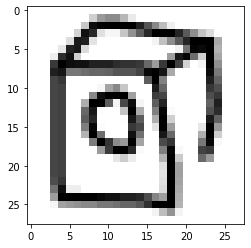

In [4]:
df = pd.read_csv('quickdraw_png_set1_train.csv', index_col=0)
df.head()

main_dir = 'quickdraw-png_set1/'

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')
plt.show()

### Create a Custom Data Loader

In [5]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [6]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally


BATCH_SIZE = 128

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                 img_dir='quickdraw-png_set1/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4) 


valid_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_valid.csv',
                                img_dir='quickdraw-png_set1/',
                                transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4) 



test_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                img_dir='quickdraw-png_set1/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4) 

In [7]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Model

The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [8]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [9]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [10]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/8290 | Cost: 2.5425
Epoch: 001/010 | Batch 0500/8290 | Cost: 0.3276
Epoch: 001/010 | Batch 1000/8290 | Cost: 0.3386
Epoch: 001/010 | Batch 1500/8290 | Cost: 0.3684
Epoch: 001/010 | Batch 2000/8290 | Cost: 0.2080
Epoch: 001/010 | Batch 2500/8290 | Cost: 0.3242
Epoch: 001/010 | Batch 3000/8290 | Cost: 0.1639
Epoch: 001/010 | Batch 3500/8290 | Cost: 0.1354
Epoch: 001/010 | Batch 4000/8290 | Cost: 0.1846
Epoch: 001/010 | Batch 4500/8290 | Cost: 0.3661
Epoch: 001/010 | Batch 5000/8290 | Cost: 0.3528
Epoch: 001/010 | Batch 5500/8290 | Cost: 0.1873
Epoch: 001/010 | Batch 6000/8290 | Cost: 0.3726
Epoch: 001/010 | Batch 6500/8290 | Cost: 0.2082
Epoch: 001/010 | Batch 7000/8290 | Cost: 0.2256
Epoch: 001/010 | Batch 7500/8290 | Cost: 0.1855
Epoch: 001/010 | Batch 8000/8290 | Cost: 0.1332
Epoch: 001/010 | Train: 93.190% | Validation: 92.841%
Time elapsed: 8.59 min
Epoch: 002/010 | Batch 0000/8290 | Cost: 0.2356
Epoch: 002/010 | Batch 0500/8290 | Cost: 0.2356
Epoch: 002/

## Evaluation

In [11]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 97.73%


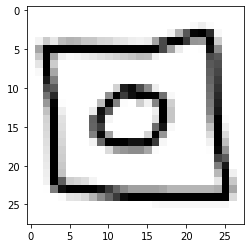

In [12]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[5], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [13]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Washing Machine %.2f%%' % (probas[0][4]*100))

Probability Washing Machine 100.00%


In [14]:
%watermark -iv

PIL.Image   6.2.0
pandas      0.24.2
torch       1.3.0
numpy       1.17.2
torchvision 0.4.1a0+d94043a
matplotlib  3.1.0

